In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import glob
import numpy as np
import tensorflow as tf

In [ ]:
print(len('/content/drive/MyDrive/Lung_Seg/Model_Xrays/'))
print(len('/content/drive/MyDrive/Lung_Seg/Masks/'))

44
38


In [ ]:
xrays = []
files = glob.glob('/content/drive/MyDrive/Lung_Seg/Masks/*.png')
for file in files:
  xrays.append(file[38:])
xrays

['JPCLN002.png',
 'JPCLN001.png',
 'JPCLN003.png',
 'JPCLN004.png',
 'JPCLN005.png',
 'JPCLN006.png',
 'JPCLN007.png',
 'JPCLN008.png',
 'JPCLN009.png',
 'JPCLN010.png',
 'JPCLN011.png',
 'JPCLN012.png',
 'JPCLN013.png',
 'JPCLN014.png',
 'JPCLN015.png',
 'JPCLN016.png',
 'JPCLN017.png',
 'JPCLN018.png',
 'JPCLN019.png',
 'JPCLN020.png',
 'JPCLN021.png',
 'JPCLN022.png',
 'JPCLN023.png',
 'JPCLN024.png',
 'JPCLN025.png',
 'JPCLN026.png',
 'JPCLN027.png',
 'JPCLN028.png',
 'JPCLN029.png',
 'JPCLN030.png',
 'JPCLN031.png',
 'JPCLN032.png',
 'JPCLN033.png',
 'JPCLN034.png',
 'JPCLN035.png',
 'JPCLN036.png',
 'JPCLN037.png',
 'JPCLN038.png',
 'JPCLN039.png',
 'JPCLN040.png',
 'JPCLN041.png',
 'JPCLN042.png',
 'JPCLN043.png',
 'JPCLN044.png',
 'JPCLN045.png',
 'JPCLN046.png',
 'JPCLN047.png',
 'JPCLN048.png',
 'JPCLN049.png',
 'JPCLN050.png',
 'JPCLN051.png',
 'JPCLN052.png',
 'JPCLN053.png',
 'JPCLN054.png',
 'JPCLN055.png',
 'JPCLN056.png',
 'JPCLN057.png',
 'JPCLN058.png',
 'JPCLN059.png

In [ ]:
print(len(xrays))

951


In [ ]:
import cv2
X = []
Y = []
for i in range(1, len(xrays), 50):
  for file in xrays[i:min(i+50, len(xrays))]:
    image = cv2.imread('/content/drive/MyDrive/Lung_Seg/Model_Xrays/'+file)
    mask = cv2.imread('/content/drive/MyDrive/Lung_Seg/Masks/'+file)
    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    X.append(image)
    Y.append(mask)


In [ ]:
print(len(X))
print(len(Y))

950
950


In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X = X/255
Y = Y/255

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Dropout, GlobalMaxPooling2D,UpSampling2D, Input, Concatenate

In [ ]:
def conv_block(input, num_filters, times=2):
  x = input
  for i in range(times):
    x = Conv2D(filters=num_filters, padding='same', kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
  
  return x

In [ ]:
def encoder(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
inputs = Input((256, 256, 3))
inputs

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
s1, p1 = encoder(inputs, 64)
s2, p2 = encoder(p1, 128)
s3, p3 = encoder(p2, 256)
s4, p4 = encoder(p3, 512)

In [ ]:
b1 = conv_block(p4, 1024)
b1

<KerasTensor: shape=(None, 16, 16, 1024) dtype=float32 (created by layer 'activation_9')>

In [ ]:
d1 = decoder(b1, s4, 512)
d2 = decoder(d1, s3, 256)
d3 = decoder(d2, s2, 128)
d4 = decoder(d3, s1, 64)

In [ ]:
d4

<KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'activation_17')>

In [ ]:
outputs = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
outputs

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'conv2d_18')>

In [ ]:
 model = tf.keras.Model(inputs, outputs, name="U-Net")
 model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import albumentations as alb
config = {
    'augm_p_corrections': 0.3,
    'augm_p_contrast': 1,
    'augm_p_gamma': 1,
    'augm_p_brightness': 1,

    'augm_p_blurs': 0.5,
    'augm_p_blur': 1,
    'augm_p_motionblur': 0.5,
    'augm_p_medianblur': 0.5,

    'augm_p_distortions': 0.3,
    'augm_p_elastic': 0.1,
    'augm_p_grid': 0.1,
    'augm_p_optical': 0.1,

    'augm_p_shiftscalrot': 0.5,
    'augm_shift_limit': 0.2,
    'augm_scale_limit': 0.1,
    'augm_rotate_limit': 8,
}

In [ ]:
augm = alb.Compose([
        alb.OneOf([
            alb.RandomContrast(p=config["augm_p_contrast"]),
            alb.RandomGamma(p=config["augm_p_gamma"]),
            alb.RandomBrightness(p=config["augm_p_brightness"]),
        ],
            p=config["augm_p_corrections"]),
        alb.OneOf([
            alb.Blur(blur_limit=4, p=config["augm_p_blur"]),
            alb.MotionBlur(blur_limit=4, p=config["augm_p_motionblur"]),
            alb.MedianBlur(blur_limit=4, p=config["augm_p_medianblur"])
        ],
            p=config["augm_p_blurs"]),
        alb.OneOf([
            alb.ElasticTransform(alpha=60,
                                 sigma=60 * 0.20,
                                 alpha_affine=60 * 0.03,
                                 p=config["augm_p_elastic"]),
            alb.GridDistortion(p=config["augm_p_grid"]),
            alb.OpticalDistortion(
                distort_limit=0.2, shift_limit=0.05, p=config["augm_p_optical"]),
        ],
            p=config["augm_p_distortions"])
    ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(760, 256, 256, 3)
(190, 256, 256, 3)
(760, 256, 256, 3)
(190, 256, 256, 3)


In [ ]:
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
print(X_valid.shape)
print(X_test.shape)
print(Y_valid.shape)
print(Y_test.shape)

(95, 256, 256, 3)
(95, 256, 256, 3)
(95, 256, 256, 3)
(95, 256, 256, 3)


In [ ]:
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [ ]:
batch_size = 5
lr = 1e-5
num_epochs = 10
model_path = "/content/drive/MyDrive/Unet/model.h5"
csv_path = "/content/drive/MyDrive/Unet/data.csv"
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[iou, Recall(), Precision()])

In [ ]:
callbacks = [
             ModelCheckpoint("/content/drive/MyDrive/Unet/model.h5", verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
             CSVLogger(csv_path)
]
history = model.fit(X_train, Y_train, batch_size=5, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks, epochs=100)

Epoch 1/100
152/152 [==============================] - ETA: 0s - loss: 0.4500 - iou: 0.3860 - recall: 0.9060 - precision: 0.5215
Epoch 1: val_loss improved from inf to 0.56979, saving model to /content/drive/MyDrive/Unet/model.h5
152/152 [==============================] - 173s 987ms/step - loss: 0.4500 - iou: 0.3860 - recall: 0.9060 - precision: 0.5215 - val_loss: 0.5698 - val_iou: 0.2744 - val_recall: 1.0000 - val_precision: 0.2750 - lr: 1.0000e-05
Epoch 2/100
152/152 [==============================] - ETA: 0s - loss: 0.2448 - iou: 0.6087 - recall: 0.9689 - precision: 0.8747
Epoch 2: val_loss improved from 0.56979 to 0.54633, saving model to /content/drive/MyDrive/Unet/model.h5
152/152 [==============================] - 139s 916ms/step - loss: 0.2448 - iou: 0.6087 - recall: 0.9689 - precision: 0.8747 - val_loss: 0.5463 - val_iou: 0.2937 - val_recall: 1.0000 - val_precision: 0.2868 - lr: 1.0000e-05
Epoch 3/100
152/152 [==============================] - ETA: 0s - loss: 0.1781 - iou: 0.6

KeyboardInterrupt: ignored

In [ ]:
model.fit(X_train, Y_train, batch_size=5, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks, epochs=100, initial_epoch=60)

Epoch 61/100
92/92 [==============================] - ETA: 0s - loss: 0.0104 - iou: 0.9794 - recall: 0.9903 - precision: 0.9928
Epoch 61: val_loss improved from 0.02216 to 0.02212, saving model to /content/drive/MyDrive/Unet/model.h5
92/92 [==============================] - 89s 968ms/step - loss: 0.0104 - iou: 0.9794 - recall: 0.9903 - precision: 0.9928 - val_loss: 0.0221 - val_iou: 0.9573 - val_recall: 0.9798 - val_precision: 0.9789 - lr: 1.0000e-07
Epoch 62/100
92/92 [==============================] - ETA: 0s - loss: 0.0105 - iou: 0.9793 - recall: 0.9903 - precision: 0.9927
Epoch 62: val_loss did not improve from 0.02212
92/92 [==============================] - 85s 918ms/step - loss: 0.0105 - iou: 0.9793 - recall: 0.9903 - precision: 0.9927 - val_loss: 0.0221 - val_iou: 0.9573 - val_recall: 0.9799 - val_precision: 0.9788 - lr: 1.0000e-07
Epoch 63/100
92/92 [==============================] - ETA: 0s - loss: 0.0105 - iou: 0.9792 - recall: 0.9903 - precision: 0.9928
Epoch 63: val_loss d

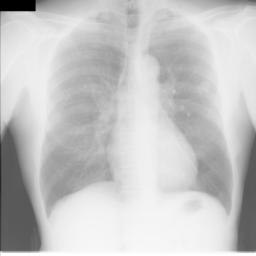

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X[0]*255)

In [ ]:
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
callbacks = [
             ModelCheckpoint(model_path, verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
             CSVLogger(csv_path)
]
model.fit(X_train, Y_train, batch_size=5, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks)

152/152 [==============================] - ETA: 0s - loss: 0.4554 - iou: 0.3816 - recall: 0.8758 - precision: 0.5039 
Epoch 1: val_loss improved from inf to 0.54904, saving model to /content/drive/MyDrive/Unet/model.h5
152/152 [==============================] - 4952s 33s/step - loss: 0.4554 - iou: 0.3816 - recall: 0.8758 - precision: 0.5039 - val_loss: 0.5490 - val_iou: 0.2915 - val_recall: 1.0000 - val_precision: 0.2787 - lr: 1.0000e-05


In [ ]:
model.fit(X_train, Y_train, batch_size=5, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks, epochs=num_epochs, initial_epoch=1)

Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.2600 - iou: 0.5889 - recall: 0.9711 - precision: 0.8586 
Epoch 2: val_loss improved from 0.54904 to 0.51768, saving model to /content/drive/MyDrive/Unet/model.h5
152/152 [==============================] - 4562s 30s/step - loss: 0.2600 - iou: 0.5889 - recall: 0.9711 - precision: 0.8586 - val_loss: 0.5177 - val_iou: 0.3183 - val_recall: 0.9997 - val_precision: 0.3164 - lr: 1.0000e-05
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.1951 - iou: 0.6745 - recall: 0.9727 - precision: 0.9129 
Epoch 3: val_loss improved from 0.51768 to 0.21055, saving model to /content/drive/MyDrive/Unet/model.h5
152/152 [==============================] - 4408s 29s/step - loss: 0.1951 - iou: 0.6745 - recall: 0.9727 - precision: 0.9129 - val_loss: 0.2106 - val_iou: 0.6526 - val_recall: 0.9405 - val_precision: 0.9154 - lr: 1.0000e-05
Epoch 4/10
152/152 [==============================] - ETA: 0s - loss: 0.1567 - iou: 0.